In [3]:
#%env MXNET_CPU_WORKER_NTHREADS=4
%env OMP_NUM_THREADS=1
import scipy.io as sio
from scipy.sparse.linalg import svds, eigs
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
import mxnet as mx
from mxnet import nd, autograd, gluon
from time import time
mx.random.seed(1)

In [4]:
x1 = np.random.rand(2000,2000)
x2 = np.random.rand(2000,2000)
start = time()
z = np.dot(x1,x2)
print(time() - start)

0.275640964508


In [5]:
start = time()
ctxts = [mx.cpu(0),mx.cpu(1)]
x1 = nd.random_uniform(shape=(2000,2000), ctx=ctxts[0])
x2 = nd.random_uniform(shape=(2000,2000), ctx=ctxts[1])
y1 = nd.dot(x1, x1)
y2 = nd.dot(x2, x2)
print('=== workloads are pushed into the backend engine ===\n%f sec' % (time() - start))
z1=y1.asnumpy()
z2=y2.asnumpy()
print('=== workloads are finished ===\n%f sec' % (time() - start))

=== workloads are pushed into the backend engine ===
0.005735 sec
=== workloads are finished ===
0.399582 sec


In [6]:
def load_data(file_name, train, tune):
    #loads the .mat file in file_name
    #returns a dictionary data, containing test, train and tune
    #the original data file is a dict with key 'X', containing the data
    #training is X[:,0:train-1], tune is X[:,train:train+tune-1]
    #test is the rest
    data_dict = sio.loadmat(file_name)
    data_matr = data_dict['X']
    data_matr = np.array(data_matr)
    (d,n) = data_matr.shape
    if (n < train):
        sys.exit("train > number of points")
    data_train = data_matr[:,0:train]
    if (train > 0):
        data_train /= np.max(np.abs(data_train))
    if (n < train+tune):
        sys.exit("train+tune > number of points")
    data_tune = data_matr[:,train:train+tune]
    if (tune > 0):
        data_tune /= np.max(np.abs(data_tune))
    data_test = data_matr[:,train+tune:]
    data_test /= np.max(np.abs(data_test))
    data = {"train":data_train,"tune":data_tune,"test":data_test}
    return data

def create_syn(n, d, decay_param, train, tune):
    #create a dxn dataset sampled from a normal with exponential decay in covariance
    decay = np.array([decay_param**(-1) for i in xrange(d)])
    X = np.random.normal(0, 1, (n,d))
    X = np.multiply(decay,X).T
    if (n < train):
        sys.exit("train > number of points")
    data_train = X[:,0:train]
    if (n < train+tune):
        sys.exit("train+tune > number of points")
    data_tune = X[:,train:train+tune]
    data_test = X[:,train+tune:]
    return {"train":data_train, "tune":data_tune, "test":data_test}

In [7]:
data = load_data('./data/xsmnist.mat', 8000, 1999)
data['test'] = data['tune']

In [8]:
data_ctx = mx.cpu()
model_ctx = mx.cpu()

In [9]:
(d,n) = data['train'].shape
k = 1
u, s, vt = svds(np.dot(data['test'],data['test'].T)/(data['test'].shape)[1],k)
obj_val = sum(s)
print (obj_val)
batch_size = 1;
train_data = mx.gluon.data.DataLoader(data['train'].T, batch_size, shuffle=True)
test_data = mx.gluon.data.DataLoader(data['test'].T, batch_size, shuffle=False)
#train_data = mx.nd.array(data['train'])
#test_data = mx.nd.array(data['test'])

1.30170732793


In [12]:
#def proj_matr(x_loading):
#    return nd.dot(U,x_loading)

def net(X, U_matr):
    #data is row-wise anyway
    return nd.dot(nd.dot(X,U_matr),U_matr.T)
    #x_loading = nd.dot(U_matr.T, X)
    #return proj_matr(x_loading)

def eval_loss(yhat,y):
    return -0.5*nd.dot(yhat,y)
    #yhat = proj_matr(nd.dot(U.T,y))
    #return -0.5*nd.dot(yhat.T,y)

def SGD(U_matr, eta, do_qr = False):
    U_matr[:] = U_matr - eta*U_matr.grad
    if(do_qr):
        Q,L = nd.linalg.gelqf(U_matr.T)
        U_matr = Q.T
        
'''def evaluate_accuracy(data_iterator, net, U_matr, true_obj):
    curr_obj = 0.0
    Q,L = nd.linalg.gelqf(U_matr.T)
    U_matr = Q.T
    for i,data in enumerate(data_iterator):
        data = data.as_in_context(model_ctx).astype(dtype='float32')
        proj_data = net(data.T, U_matr)
        curr_obj += nd.norm(nd.dot(U_matr.T,data.T))*nd.norm(nd.dot(U_matr.T,data.T))
    return true_obj - curr_obj/(1.0*(i+1))'''

def evaluate_accuracy(data, U_matr, true_obj):
    Q,L = nd.linalg.gelqf(U_matr.T)
    U_matr = Q.T
    data = nd.array(data)
    obj_sqrt = nd.norm(nd.dot(U_matr.T,data))
    return true_obj - obj_sqrt*obj_sqrt/(data.shape)[1]

def train(data, k, epochs, batch_size, learning_rate, te_accs, tr_accs):
    (d,n) = data['train'].shape
    U = nd.random_normal(shape = (d,k), ctx=model_ctx)
    Q,L = nd.linalg.gelqf(U.T)
    U = Q.T
    U.attach_grad()
    u, s, vt = svds(np.dot(data['test'],data['test'].T)/(data['test'].shape)[1],k)
    obj_val = sum(s)
    train_data = mx.gluon.data.DataLoader(data['train'].T, batch_size, shuffle=True)
    test_data = mx.gluon.data.DataLoader(data['test'].T, batch_size, shuffle=True)
    start = time()
    for e in range(epochs):
        for i, data_t in enumerate(train_data):
            data_t = data_t.as_in_context(model_ctx).astype(dtype='float32')
            with autograd.record():
                output = net(data_t, U)
                loss = eval_loss(output,data_t.T)
            loss.backward()
            #compare = nd.dot(data_t.T,nd.dot(data_t,U))
            if (i%200==0):
                SGD(U, learning_rate/(i+1), True)
                te_accs.append((evaluate_accuracy(data['test'], U, obj_val).asnumpy()[0], time() - start))
                tr_accs.append((evaluate_accuracy(data['train'], U, obj_val).asnumpy()[0], time() - start))
            else:
                SGD(U, learning_rate/(i+1))
        test_accuracy = evaluate_accuracy(data['test'], U, obj_val)
        train_accuracy = evaluate_accuracy(data['train'], U, obj_val)
        print("Epoch %s. Train_err %s, Test_err %s" % (e, train_accuracy, test_accuracy))
    return U


In [13]:
#data = load_data('./data/xsmnist.mat', 8000, 0)
data = create_syn(50000, 2000, 1.1, 40000, 5000)
print(data['train'].shape)
epochs = 3
batch_size = 5
learning_rate = .05
k = 1;
te_accs = []
tr_accs = []
U = train(data, k, epochs, batch_size, learning_rate, te_accs, tr_accs)

(50000, 2000)


KeyboardInterrupt: 

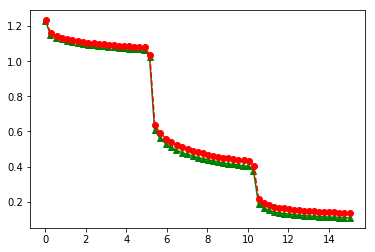

In [50]:
y_test = list(zip(*te_accs)[0])
x_test = list(zip(*te_accs)[1])
plt.plot(x_test,y_test, "-g^", label="test error")
y_train = list(zip(*tr_accs)[0])
x_train = list(zip(*tr_accs)[1])
plt.plot(x_train,y_train, "--ro", label="train error")
plt.show()

In [50]:
cpus = [mx.cpu(0),mx.cpu(1)]
b = [mx.nd.ones((2,3),cpu) for cpu in cpus]
print b
kv = mx.kv.create('dist_async')
kv.init(3, mx.nd.ones((2,3))*2)
a = mx.nd.zeros((2,3))
kv.push(3,b)
kv.pull(3, out = a)
print a.asnumpy

[
[[ 1.  1.  1.]
 [ 1.  1.  1.]]
<NDArray 2x3 @cpu(0)>, 
[[ 1.  1.  1.]
 [ 1.  1.  1.]]
<NDArray 2x3 @cpu(1)>]


MXNetError: [02:08:14] src/postoffice.cc:16: Check  notnull: Environment::Get()->find("DMLC_NUM_WORKER") 

Stack trace returned 9 entries:
[bt] (0) 0   libmxnet.so                         0x000000010f4091f8 _ZN4dmlc15LogMessageFatalD2Ev + 40
[bt] (1) 1   libmxnet.so                         0x0000000110575241 _ZN2ps10PostofficeC2Ev + 1473
[bt] (2) 2   libmxnet.so                         0x0000000110572f00 _ZN2ps8CustomerC2EiRKNSt3__18functionIFvRKNS_7MessageEEEE + 512
[bt] (3) 3   libmxnet.so                         0x00000001102c7c2b _ZN2ps8KVWorkerIfEC2Ei + 603
[bt] (4) 4   libmxnet.so                         0x000000011029c41b _ZN5mxnet7kvstore11KVStoreDistC2Eb + 379
[bt] (5) 5   libmxnet.so                         0x000000011029c066 _ZN5mxnet7KVStore6CreateEPKc + 806
[bt] (6) 6   libmxnet.so                         0x00000001101b88be MXKVStoreCreate + 14
[bt] (7) 7   _ctypes.so                          0x000000010b7de7c7 ffi_call_unix64 + 79
[bt] (8) 8   ???                                 0x00007ffee4e452f0 0x0 + 140732738589424
